<a href="https://colab.research.google.com/github/ChapelFob80930/AI-Generated-Text-Detector/blob/main/AITextTest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing the Dataset**

In [1]:
import numpy as np
import pandas as pd

ai_generated_dataset = pd.read_csv("/content/train_v2_drcat_02.csv")
print(ai_generated_dataset.shape)
ai_generated_dataset = ai_generated_dataset.dropna()
ai_generated_dataset = ai_generated_dataset.drop(columns=['prompt_name','source','RDizzl3_seven'])
print(ai_generated_dataset.head())
print(ai_generated_dataset.shape)

(44868, 5)
                                                text  label
0  Phones\n\nModern humans today are always on th...      0
1  This essay will explain if drivers should or s...      0
2  Driving while the use of cellular devices\n\nT...      0
3  Phones & Driving\n\nDrivers should not be able...      0
4  Cell Phone Operation While Driving\n\nThe abil...      0
(44868, 2)


In [2]:
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

#**Preprocessing Data**

In [4]:
import numpy as np
import pandas as pd
import spacy
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
import re


nlp = spacy.load('en_core_web_sm')


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]","",text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)


def parallel_preprocessing(series):
    """Preprocess text using spaCy, parallel processing, and tqdm for progress tracking."""
    tqdm.pandas()
    return Parallel(n_jobs=10, backend="multiprocessing")(delayed(preprocess)(text) for text in tqdm(series, desc="Preprocessing"))


ai_generated_dataset["preprocessedText"] = parallel_preprocessing(ai_generated_dataset["text"])

print(ai_generated_dataset.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  
0  phone modern human today always phone always p...  
1  essay explain driver able use electronic devic...  
2  drive use cellular device today society though...  
3  phone drive driver able use phone operate vehi...  
4  cell phone operation drive ability stay connec...  


#**Creating Word2Vec Embeddings**

In [5]:
from gensim.models import Word2Vec

sentences = ai_generated_dataset["preprocessedText"].apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences, vector_size=300, window=10, min_count=2, workers=4, sg=1)

word_vector = word2vec_model.wv['car']
print("Vector for 'car':", word_vector)


def calculate_average_word_vector(words,model,vector_size=300):
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

def parallel_word2vec(row):
    return calculate_average_word_vector(row.split(), word2vec_model)


ai_generated_dataset['word2vecVector'] = Parallel(n_jobs=10,backend='multiprocessing')(delayed(parallel_word2vec)(row) for row in tqdm(ai_generated_dataset["preprocessedText"], desc="Word2Vec"))
print(ai_generated_dataset.head())



Vector for 'car': [ 0.09131698  0.29528412 -0.27284387  0.05139103  0.03846934  0.00476515
 -0.27984607 -0.07858433 -0.07743984 -0.06548931 -0.03796072 -0.19587553
  0.23202066 -0.03581011 -0.30424985  0.30604485  0.6617226  -0.05272839
  0.07908552  0.26181546  0.05931774  0.06650639 -0.0306376   0.00739211
 -0.21041052  0.3335409   0.08317763  0.29440182  0.23472047 -0.25034904
 -0.06594107  0.15823546 -0.02843368  0.04741255 -0.10266607  0.3360326
  0.1290874  -0.19825453 -0.24478342 -0.1188971   0.06264783  0.02316411
 -0.281981   -0.14029409  0.14801437  0.30068958  0.29541233  0.30913574
 -0.5572026  -0.00079131 -0.03472793 -0.12123156 -0.19851986 -0.15308888
  0.14258908  0.01474613 -0.22156298 -0.00345795 -0.28504032  0.01686772
  0.12449133 -0.4479222   0.03261058  0.08383605  0.04374932  0.22832455
  0.14589384  0.03563403 -0.07401107  0.3915732   0.22356692 -0.27455026
  0.16668862 -0.21201806 -0.5196088  -0.03979636  0.09489086 -0.15122229
 -0.20596795  0.12930591 -0.033865

Word2Vec:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  \
0  phone modern human today always phone always p...   
1  essay explain driver able use electronic devic...   
2  drive use cellular device today society though...   
3  phone drive driver able use phone operate vehi...   
4  cell phone operation drive ability stay connec...   

                                      word2vecVector  
0  [0.0947627, 0.15983818, -0.044149067, 0.130929...  
1  [0.097245194, 0.13757715, 0.017097821, 0.13159...  
2  [0.028974527, 0.1540339, 0.035483517, 0.103220...  
3  [0.07914372, 0.17274155, 0.08078173, 0.0825335...  
4  [0.083

#**Creating Doc2Vec Embeddings**

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def prepare_tagged_documents(series):

    return [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(series)]


tqdm.pandas(desc="Preparing Tagged Documents")
tagged_data = prepare_tagged_documents(tqdm(ai_generated_dataset["preprocessedText"], desc="Tagging Data"))


doc2vec_model = Doc2Vec(tagged_data, vector_size=300, window=5, min_count=2, workers=4, dm=1,epochs=50)

# Function to generate Doc2Vec vectors
def generate_doc2vec_vector(index):

    return doc2vec_model.dv[str(index)]

# Use tqdm and joblib to parallelize vector generation
def generate_doc2vec_vectors_parallel(dataframe):

    indices = dataframe.index
    return Parallel(n_jobs=10, backend="multiprocessing")(delayed(generate_doc2vec_vector)(index) for index in tqdm(indices, desc="Generating Doc2Vec Vectors"))

ai_generated_dataset['doc2vecVector'] = generate_doc2vec_vectors_parallel(ai_generated_dataset)


print(ai_generated_dataset.head())


Tagging Data:   0%|          | 0/44868 [00:00<?, ?it/s]

Generating Doc2Vec Vectors:   0%|          | 0/44868 [00:00<?, ?it/s]

                                                text  label  \
0  Phones\n\nModern humans today are always on th...      0   
1  This essay will explain if drivers should or s...      0   
2  Driving while the use of cellular devices\n\nT...      0   
3  Phones & Driving\n\nDrivers should not be able...      0   
4  Cell Phone Operation While Driving\n\nThe abil...      0   

                                    preprocessedText  \
0  phone modern human today always phone always p...   
1  essay explain driver able use electronic devic...   
2  drive use cellular device today society though...   
3  phone drive driver able use phone operate vehi...   
4  cell phone operation drive ability stay connec...   

                                      word2vecVector  \
0  [0.0947627, 0.15983818, -0.044149067, 0.130929...   
1  [0.097245194, 0.13757715, 0.017097821, 0.13159...   
2  [0.028974527, 0.1540339, 0.035483517, 0.103220...   
3  [0.07914372, 0.17274155, 0.08078173, 0.0825335...   
4  [

#**Splitting the Test and Train indexes and Separating the Labels from the Data**

In [8]:
from sklearn.model_selection import train_test_split

y = ai_generated_dataset['label']

train_index, test_index = train_test_split(ai_generated_dataset.index, test_size=0.3, random_state=42, stratify = y)


In [9]:
print(train_index.shape)
print(test_index.shape)

(31407,)
(13461,)


#**Creating TF-IDF Embeddings and Applying SMOTE**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,3),max_df=0.95,min_df=2,sublinear_tf=True)
X_tfidf = tfidf_vectorizer.fit_transform(ai_generated_dataset["preprocessedText"])

X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
y_train, y_test = y[train_index], y[test_index]


In [11]:
print(X_train_tfidf.shape)

(31407, 5000)


In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_tfidf_balanced = smote.fit_resample(X_train_tfidf, y_train)
print("TF-IDF Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("TF-IDF After SMOTE: ",dict(zip(*np.unique(y_train_tfidf_balanced, return_counts=True))))

TF-IDF Before SMOTE:  {0: 19159, 1: 12248}
TF-IDF After SMOTE:  {0: 19159, 1: 19159}


#**Splitting Word2Vec Embeddings into Train and Test Datasets and Applying SMOTE**

In [13]:
ai_generated_dataset['word2vecVector'] = ai_generated_dataset['word2vecVector'].apply(lambda x: np.array(x))

X_word2vec = np.stack(ai_generated_dataset['word2vecVector'].values)

X_train_word2vec, X_test_word2vec = X_word2vec[train_index], X_word2vec[test_index]

print(X_train_word2vec.shape)
print(X_test_word2vec.shape)
print(X_train_word2vec)

(31407, 300)
(13461, 300)
[[ 0.039051    0.10478925 -0.10349992 ...  0.00596908  0.13902527
  -0.07503184]
 [ 0.10214149  0.03306101 -0.07900619 ...  0.0649736   0.06864601
   0.00100042]
 [ 0.13359068  0.11844996 -0.05979795 ...  0.04451644  0.09243853
  -0.05382077]
 ...
 [ 0.09989098  0.20183747 -0.07830133 ...  0.06512829  0.13320415
  -0.01214189]
 [ 0.16594312  0.1734943  -0.11123574 ...  0.06146725  0.14685261
   0.0111135 ]
 [ 0.11314496  0.15538785 -0.05687832 ...  0.0446307   0.20486088
  -0.07738265]]


In [14]:
X_train_word2vec_balanced, y_train_word2vec_balanced = smote.fit_resample(X_train_word2vec, y_train)
print("Word2Vec Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("Word2Vec After SMOTE: ",dict(zip(*np.unique(y_train_word2vec_balanced, return_counts=True))))

Word2Vec Before SMOTE:  {0: 19159, 1: 12248}
Word2Vec After SMOTE:  {0: 19159, 1: 19159}


#**Splitting Doc2Vec Embeddings into Train and Test Datasets and Applying SMOTE**

In [15]:
ai_generated_dataset['doc2vecVector'] = ai_generated_dataset['doc2vecVector'].apply(lambda x: np.array(x))
X_doc2vec = np.stack(ai_generated_dataset['doc2vecVector'].values)
X_train_doc2vec, X_test_doc2vec = X_doc2vec[train_index], X_doc2vec[test_index]
print(X_train_doc2vec.shape)
print(X_test_doc2vec.shape)
print(X_train_doc2vec)

(31407, 300)
(13461, 300)
[[-0.01325695 -0.00462023 -0.25115326 ... -0.81993866  0.27462918
   0.2054378 ]
 [ 0.27893692 -1.3015618  -0.22397842 ...  1.0865633   0.28704125
  -0.8185667 ]
 [ 0.348895   -0.03381492  0.80767345 ... -0.03958359  1.2685198
  -0.2265202 ]
 ...
 [-1.2151754   0.9092739  -1.5415982  ... -0.3269651   1.0781606
   0.6174968 ]
 [ 0.09335165  0.21354501  0.3036163  ... -0.10610441  0.9039201
  -1.4429867 ]
 [-0.6302537  -0.71300817 -0.33029798 ...  0.6759022   0.43423736
   0.00538663]]


In [16]:
X_train_doc2vec_balanced, y_train_doc2vec_balanced = smote.fit_resample(X_train_doc2vec, y_train)
print("Doc2Vec Before SMOTE: ",dict(zip(*np.unique(y_train, return_counts=True))))
print("Doc2Vec After SMOTE: ",dict(zip(*np.unique(y_train_doc2vec_balanced, return_counts=True))))

Doc2Vec Before SMOTE:  {0: 19159, 1: 12248}
Doc2Vec After SMOTE:  {0: 19159, 1: 19159}


# **Importing Models**

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def evaluate_model_with_visualizations(model, X_train, X_test, y_train, y_test, model_name, embedding_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Performing 5-Fold Cross-Validation for {model_name} with {embedding_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(f"{model_name} with {embedding_name} - Cross-validation Scores: {cv_scores}")
    print(f"{model_name} with {embedding_name} - Mean CV Accuracy: {cv_scores.mean():.4f}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name} with {embedding_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"{model_name} with {embedding_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, alpha=0.6, label='Predicted', marker='x')
    plt.title(f'Scatter Plot: {model_name} with {embedding_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Labels')
    plt.legend()
    plt.show()

In [18]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
print(ai_generated_dataset['label'].value_counts(normalize=True))

label
0    0.610034
1    0.389966
Name: proportion, dtype: float64


#**Implementing SVM on Different Types of Embeddings and Comparing Results**

In [ ]:
svm_model_tfidf = SVC(class_weight='balanced',random_state=42,kernel='rbf',gamma='scale',C=1)
evaluate_model_with_visualizations(svm_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "SVM", "TF-IDF")

Performing 5-Fold Cross-Validation for SVM with TF-IDF...


In [ ]:
svm_model_word2vec = SVC(class_weight='balanced',random_state=42, C=1, kernel='rbf', gamma='scale')
evaluate_model_with_visualizations(svm_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "SVM", "Word2Vec")

In [ ]:
svm_model_doc2vec = SVC(class_weight='balanced',random_state=42, C=1, kernel='rbf', gamma='scale')
evaluate_model_with_visualizations(svm_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "SVM", "Doc2Vec")

#**Implementing Decision Tree on Different Types of Embeddings and Comparing Results**

In [ ]:
decision_tree_model_tfidf = DecisionTreeClassifier(class_weight='balanced',random_state=42, criterion='gini',max_depth=None,min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "Decision Tree", "TF-IDF")

In [ ]:
decision_tree_model_word2vec = DecisionTreeClassifier(class_weight='balanced',random_state=42, criterion='gini', max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "Decision Tree", "Word2Vec")

In [ ]:
decision_tree_model_doc2vec = DecisionTreeClassifier(class_weight='balanced',random_state=42, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(decision_tree_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "Decision Tree", "Doc2Vec")

#**Implementing Random Forest on Different Types of Embeddings and Comparing Results**

In [ ]:
random_forest_model_tfidf = RandomForestClassifier(class_weight='balanced', random_state=42,n_estimators=200,max_depth=None,min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "Random Forest", "TF-IDF")

In [ ]:
random_forest_model_word2vec = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators=200, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "Random Forest", "Word2Vec")

In [ ]:
random_forest_model_doc2vec = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators=200, max_depth=None, min_samples_split=5)
evaluate_model_with_visualizations(random_forest_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "Random Forest", "Doc2Vec")

#**Implementing KNN on Different Types of Embeddings and Comparing Results**

Performing 5-Fold Cross-Validation for KNN with TF-IDF...
KNN with TF-IDF - Cross-validation Scores: [0.9829071  0.97886221 0.98342902 0.98094741 0.98094741]
KNN with TF-IDF - Mean CV Accuracy: 0.9814


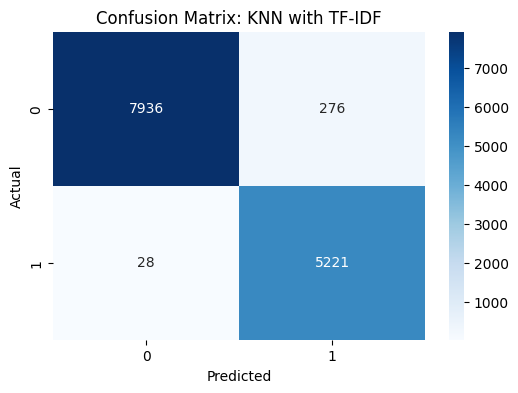

KNN with TF-IDF - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8212
           1       0.95      0.99      0.97      5249

    accuracy                           0.98     13461
   macro avg       0.97      0.98      0.98     13461
weighted avg       0.98      0.98      0.98     13461



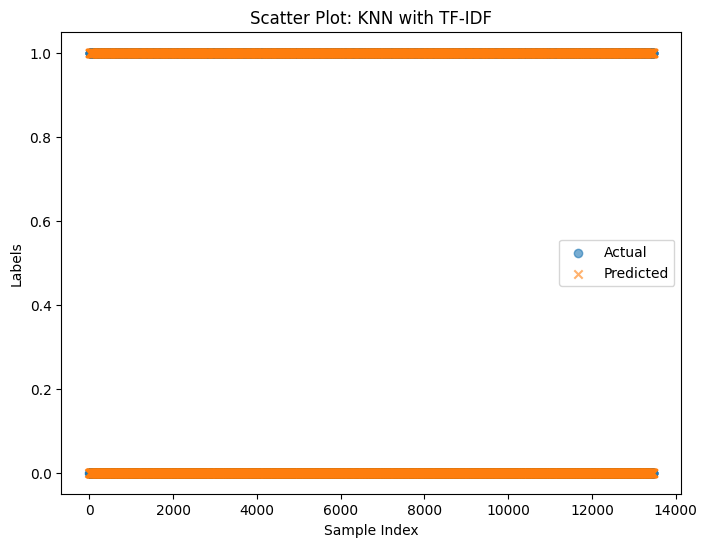

In [ ]:
# error_rate = []
# for n in range(1,11):
knn_model_tfidf = KNeighborsClassifier(n_neighbors=8,weights='distance',metric='cosine')
evaluate_model_with_visualizations(knn_model_tfidf, X_train_tfidf_balanced, X_test_tfidf, y_train_tfidf_balanced, y_test, "KNN", "TF-IDF")
  # knn_model_tfidf.score(X_test_tfidf,y_test)
  # error_rate.append(1-knn_model_tfidf.score(X_test_tfidf,y_test))
# plt.plot(error_rate)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')
# plt.show()

Performing 5-Fold Cross-Validation for KNN with Word2Vec...
KNN with Word2Vec - Cross-validation Scores: [0.99099687 0.99151879 0.99360647 0.9908652  0.9907347 ]
KNN with Word2Vec - Mean CV Accuracy: 0.9915


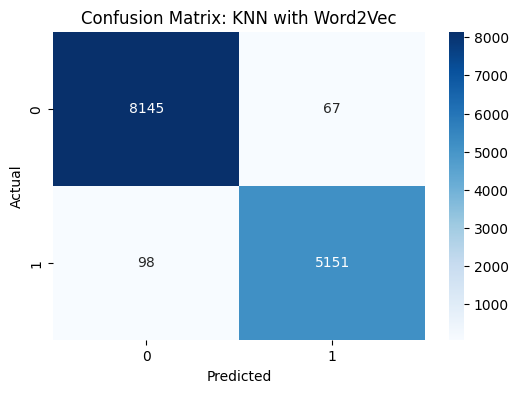

KNN with Word2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8212
           1       0.99      0.98      0.98      5249

    accuracy                           0.99     13461
   macro avg       0.99      0.99      0.99     13461
weighted avg       0.99      0.99      0.99     13461



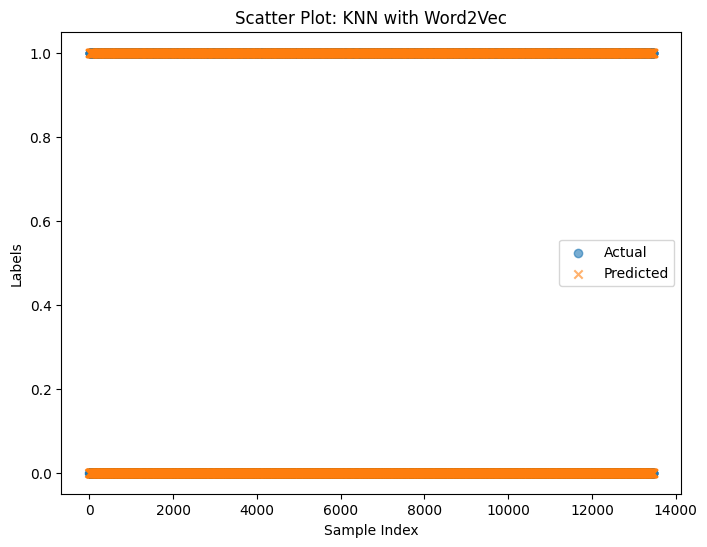

In [ ]:
# error_rate = []
# for n in range(1,11):
knn_model_word2vec = KNeighborsClassifier(n_neighbors=10,weights='distance',metric='cosine')
evaluate_model_with_visualizations(knn_model_word2vec, X_train_word2vec_balanced, X_test_word2vec, y_train_word2vec_balanced, y_test, "KNN", "Word2Vec")
  # knn_model_word2vec.score(X_test_word2vec,y_test)
  # error_rate.append(1-knn_model_word2vec.score(X_test_word2vec,y_test))
# plt.plot(error_rate)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')
# plt.xticks(range(1,11))
# plt.show()

Performing 5-Fold Cross-Validation for KNN with Doc2Vec...
KNN with Doc2Vec - Cross-validation Scores: [0.72977557 0.72377349 0.72990605 0.71551612 0.72360694]
KNN with Doc2Vec - Mean CV Accuracy: 0.7245


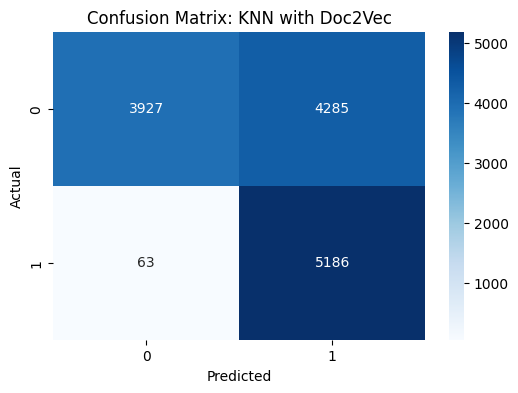

KNN with Doc2Vec - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.48      0.64      8212
           1       0.55      0.99      0.70      5249

    accuracy                           0.68     13461
   macro avg       0.77      0.73      0.67     13461
weighted avg       0.81      0.68      0.67     13461



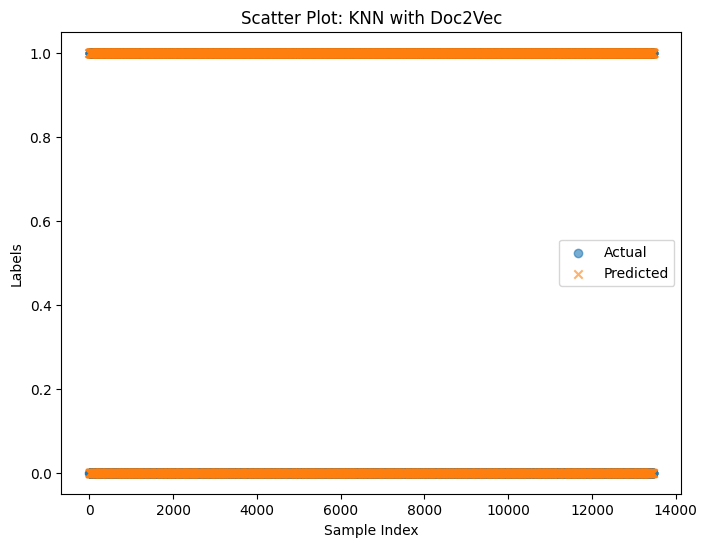

In [ ]:
# error_rate = []
# for n in range(1,11):
knn_model_doc2vec = KNeighborsClassifier(n_neighbors=1,weights='distance',metric='cosine')
evaluate_model_with_visualizations(knn_model_doc2vec, X_train_doc2vec_balanced, X_test_doc2vec, y_train_doc2vec_balanced, y_test, "KNN", "Doc2Vec")
  # knn_model_doc2vec.score(X_test_doc2vec,y_test)
  # error_rate.append(1-knn_model_doc2vec.score(X_test_doc2vec,y_test))
# plt.plot(error_rate)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')
# plt.xticks(range(1,11))
# plt.show()

#**Implementing the best embedding technique for each model and using it on custom data**


#1.   SVM :- TF-IDF
#2.   Decision Tree :- Word2Vec
#3.   Random Forest :- TF-IDF
#4.   KNN :- Word2Vec  



In [ ]:
# svm_model = SVC(class_weight='balanced',random_state=42)
# svm_model.fit(X_train_tfidf, y_train)

# decision_tree_model = DecisionTreeClassifier(random_state=42)
# decision_tree_model.fit(X_train_word2vec, y_train)

# random_forest_model = RandomForestClassifier(random_state=42)
# random_forest_model.fit(X_train_tfidf, y_train)

# knn_model = KNeighborsClassifier(n_neighbors=3)
# knn_model.fit(X_train_word2vec, y_train)

In [ ]:
custom_data = input()
#custom_data = "Good Morning Everyone, I am your teacher for today"
preprocessed_custom_data = preprocess(custom_data)
print(preprocessed_custom_data)
#for word in preprocessed_custom_data.split():
#    if word not in word2vec_model.wv:
#        print(f"Missing word: {word}")

custom_data_tfidf = tfidf_vectorizer.transform([preprocessed_custom_data])

#def update_word2vec_with_custom_data(preprocessed_data, word2vec_model):
#    """Updating Word2Vec model with custom data if new words are found."""
#    new_sentences = [preprocessed_data.split()]

#    word2vec_model.build_vocab(new_sentences, update=True)
#    word2vec_model.train(new_sentences, total_examples=len(new_sentences), epochs=5)


#update_word2vec_with_custom_data(preprocessed_custom_data, word2vec_model)

#custom_data_word2vec = [calculate_average_word_vector(preprocessed_custom_data.split(), word2vec_model, word2vec_model.vector_size)]
custom_data_word2vec = np.array([calculate_average_word_vector(preprocessed_custom_data.split(), word2vec_model, word2vec_model.vector_size)]).reshape(1, -1)

print(custom_data_tfidf.shape)
print(custom_data_word2vec.shape)


prediction_svm = svm_model_tfidf.predict(custom_data_tfidf)
print("Prediction using SVM using TF-IDF:", prediction_svm)
prediction_svm = svm_model_word2vec.predict(custom_data_word2vec)
print("Prediction using SVM using Word2Vec:", prediction_svm)

prediction_decision_tree = decision_tree_model_tfidf.predict(custom_data_tfidf)
print("Prediction using Decision Tree using TF-IDF:", prediction_decision_tree)
prediction_decision_tree = decision_tree_model_word2vec.predict(custom_data_word2vec)
print("Prediction using Decision Tree using Word2Vec:", prediction_decision_tree)

prediction_random_forest = random_forest_model_tfidf.predict(custom_data_tfidf)
print("Prediction using Random Forest using TF-IDF:", prediction_random_forest)
prediction_random_forest = random_forest_model_word2vec.predict(custom_data_word2vec)
print("Prediction using Random Forest using Word2Vec:", prediction_random_forest)

prediction_knn = knn_model_tfidf.predict(custom_data_tfidf)
print("Prediction using KNN using TF-IDF:", prediction_knn)
prediction_knn = knn_model_word2vec.predict(custom_data_word2vec)
print("Prediction using KNN using Word2Vec:", prediction_knn)

Term Frequency - Inverse Document Frequency (TF-IDF) is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus).  Words within a text document are transformed into importance numbers by a text vectorization process. There are many different text vectorization scoring schemes, with TF-IDF being one of the most common.
term frequency inverse document frequency tfidf widely use statistical method natural language processing information retrieval measure important term within document relative collection document ie relative corpus word within text document transform importance number text vectorization process many different text vectorization scoring scheme tfidf one common
(1, 5000)
(1, 300)
Prediction using KNN using TF-IDF: [0]
Prediction using KNN using Word2Vec: [1]
